In [1]:
import torchhd
from torchhd.datasets import AirfoilSelfNoise
from torchhd import embeddings
import level

/Users/mikeheddes/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import torchmetrics
from tqdm import tqdm

In [3]:
DIMENSIONS = 10_000

In [4]:
class RegHD(nn.Module):
    def __init__(self, num_features, requires_grad=False) -> None:
        super(RegHD, self).__init__()
        
        self.num_features = num_features
        weight = torch.zeros(1, num_features)
        self.weight = nn.Parameter(weight, requires_grad)
    
    @torch.no_grad()
    def model_update(self, input, target, lr=0.00001):
        error = target - F.linear(input, self.weight)
        update = torch.sum(lr * error * input, dim=0)
        self.weight.add_(update)
        
    def forward(self, input):
        return F.linear(input, self.weight)

In [319]:
class LevelHV(nn.Module):
    def __init__(self, num_features, num_levels=100, randomness=2.0, requires_grad=False) -> None:
        super(LevelHV, self).__init__()

        self.num_levels = num_levels
        self.num_features = num_features

        self.levels = level.Levels(randomness, num_features, low=0, high=1)
        self.memory = self.levels(torch.linspace(0, 1, self.num_levels))

        weight = torch.zeros(1, num_features)
        self.weight = nn.Parameter(weight, requires_grad)

        self.correct = 0
    
    @torch.no_grad()
    def add(self, input, target):
        target_vec = self.levels(target)
        input_target_pairs = torchhd.hash_table(input, target_vec)
        self.weight.add_(input_target_pairs)

    @torch.no_grad()
    def add_missing(self, input, target, alpha=1.0):
        target_vec = self.levels(target)
        predict_vec = torchhd.bind(self.weight, torchhd.inverse(input)).sign()

        similarity = torchhd.cosine_similarity(predict_vec.unsqueeze(-2), target_vec.unsqueeze(-2)).squeeze()
        is_wrong = similarity < alpha

        self.correct += (~is_wrong).sum().item()

        if is_wrong.sum().item() == 0:
            return

        input_target_pairs = torchhd.hash_table(input[is_wrong], target_vec[is_wrong])
        self.weight.add_(input_target_pairs)

    @torch.no_grad()
    def add_missing_topk(self, input, target, k=1):
        target_vec = self.levels(target)
        target_idx = torchhd.value_to_index(
            target, self.levels.low, self.levels.high, self.num_levels
        ).clamp(min=0, max=self.num_levels - 1).unsqueeze(-1)

        predict_vec = torchhd.bind(self.weight, torchhd.inverse(input)).sign()

        similarity = torchhd.dot_similarity(predict_vec.unsqueeze(-2), self.memory).squeeze(-2)
        topk = torch.topk(similarity, k, dim=-1)

        not_topk = torch.sum(target_idx == topk.indices, dim=-1) < 1
        self.correct += (~not_topk).sum().item()

        if not_topk.sum().item() == 0:
            return

        input_target_pairs = torchhd.hash_table(input[not_topk], target_vec[not_topk])
        self.weight.add_(input_target_pairs)
        
        # input_target_pairs = torchhd.hash_table(input[not_topk], predict_vec[not_topk])
        # self.weight.sub_(input_target_pairs)
        
    def forward(self, input):
        predict_vec = torchhd.bind(self.weight, torchhd.inverse(input)).sign()
        similarity = torchhd.dot_similarity(predict_vec, self.memory)
        return similarity
    
    def argmax(self, similarity):
        level_idx = torch.argmax(similarity, dim=-1, keepdim=True)
        return (level_idx / (self.num_levels - 1)) * (self.levels.high - self.levels.low) + self.levels.low

    def weighted_sum(self, similarity):
        weight = similarity - torch.min(similarity, dim=-1, keepdim=True).values
        weight = weight / torch.sum(weight, dim=-1, keepdim=True)
        values = (torch.arange(self.num_levels) / (self.num_levels - 1)) * (self.levels.high - self.levels.low) + self.levels.low
        return weight @ values.unsqueeze(-1)

    def softmax(self, similarity):
        weight = torch.softmax(similarity, dim=-1)
        values = (torch.arange(self.num_levels) / (self.num_levels - 1)) * (self.levels.high - self.levels.low) + self.levels.low
        return weight @ values.unsqueeze(-1)

In [6]:
dataset = AirfoilSelfNoise('data', download=True)

DATA_STD = dataset.data.std(0)
DATA_MEAN = dataset.data.mean(0)
TARGET_STD = dataset.targets.std(0)
TARGET_MEAN = dataset.targets.mean(0)
DATA_MIN = dataset.data.min(0).values
DATA_MAX = dataset.data.max(0).values
TARGET_MIN = dataset.targets.min(0).values
TARGET_MAX = dataset.targets.max(0).values

Files already downloaded and verified


In [7]:
class NormalTransform:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, input):
        return (input - self.mean) / self.std

class MinMaxTransform:
    def __init__(self, min, max):
        self.min = min
        self.max = max

    def __call__(self, input):
        return (input - self.min) / (self.max - self.min)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

In [8]:
item, label = dataset[0]
print(item)
print(label)

tensor([8.0000e+02, 0.0000e+00, 3.0480e-01, 7.1300e+01, 2.6634e-03])
tensor(126.2010)


In [474]:
model = RegHD(DIMENSIONS)

# encoder = embeddings.Projection(5, DIMENSIONS)
encoder = embeddings.Sinusoid(5, DIMENSIONS)
# encoder = embeddings.Density(5, DIMENSIONS)

dataset.transform = NormalTransform(DATA_MEAN, DATA_STD)
# dataset.transform = MinMaxTransform(DATA_MIN, DATA_MAX)
dataset.target_transform = NormalTransform(TARGET_MEAN, TARGET_STD)

train_dataloader = DataLoader(train_data, batch_size=12, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1)

In [475]:
with torch.no_grad():
    for epoch in range(5):
        for samples, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
            samples_hv = encoder(samples).sign()
            model.model_update(samples_hv, labels.unsqueeze(-1))

Epoch 5: 100%|██████████| 88/88 [00:00<00:00, 805.14it/s]


In [476]:
mse = torchmetrics.MeanSquaredError()

with torch.no_grad():
    for samples, labels in tqdm(test_dataloader, desc="Testing"):
        samples_hv = encoder(samples).sign()
        predictions = model(samples_hv)
        predictions = predictions * TARGET_STD + TARGET_MEAN
        labels = labels * TARGET_STD + TARGET_MEAN
        mse.update(predictions.cpu(), labels.unsqueeze(-1))

print(f"Testing mean squared error of {(mse.compute().item()):.3f}")

Testing: 100%|██████████| 451/451 [00:00<00:00, 4322.28it/s]

Testing mean squared error of 11.033


In [480]:
model = LevelHV(DIMENSIONS, randomness=5)

# encoder = embeddings.Projection(5, DIMENSIONS)
# encoder = embeddings.Sinusoid(5, DIMENSIONS)
encoder = embeddings.Density(5, DIMENSIONS)

dataset.transform = NormalTransform(DATA_MEAN, DATA_STD)
# dataset.transform = MinMaxTransform(DATA_MIN, DATA_MAX)
# dataset.target_transform = NormalTransform(TARGET_MEAN, TARGET_STD)
dataset.target_transform = MinMaxTransform(TARGET_MIN, TARGET_MAX)

train_dataloader = DataLoader(train_data, batch_size=12, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=12)

In [481]:
with torch.no_grad():
    for epoch in range(5):
        for samples, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
            samples_hv = encoder(samples).sign()
            # model.add(samples_hv, labels)
            # model.add_missing(samples_hv, labels, 0.15)
            model.add_missing_topk(samples_hv, labels, 8)

        print(model.correct)

Epoch 1: 100%|██████████| 88/88 [00:00<00:00, 327.54it/s]


192


Epoch 2: 100%|██████████| 88/88 [00:00<00:00, 374.60it/s]


398


Epoch 3: 100%|██████████| 88/88 [00:00<00:00, 370.80it/s]


622


Epoch 4: 100%|██████████| 88/88 [00:00<00:00, 374.22it/s]


855


Epoch 5: 100%|██████████| 88/88 [00:00<00:00, 375.03it/s]

1065


In [482]:
mse_argmax = torchmetrics.MeanSquaredError()
mse_weighted = torchmetrics.MeanSquaredError()
mse_softmax = torchmetrics.MeanSquaredError()

with torch.no_grad():
    for samples, labels in tqdm(test_dataloader, desc="Testing"):
        samples_hv = encoder(samples).sign()
        similarity = model(samples_hv)

        predictions_1 = model.argmax(similarity)
        predictions_2 = model.weighted_sum(similarity)
        predictions_3 = model.softmax(similarity / 200)

        predictions_1 = predictions_1 * (TARGET_MAX - TARGET_MIN) + TARGET_MIN
        predictions_2 = predictions_2 * (TARGET_MAX - TARGET_MIN) + TARGET_MIN
        predictions_3 = predictions_3 * (TARGET_MAX - TARGET_MIN) + TARGET_MIN

        labels = labels * (TARGET_MAX - TARGET_MIN) + TARGET_MIN

        mse_argmax.update(predictions_1.cpu(), labels.unsqueeze(-1))
        mse_weighted.update(predictions_2.cpu(), labels.unsqueeze(-1))
        mse_softmax.update(predictions_3.cpu(), labels.unsqueeze(-1))

print(f"Testing argmax mean squared error of {(mse_argmax.compute().item()):.3f}")
print(f"Testing weighted mean squared error of {(mse_weighted.compute().item()):.3f}")
print(f"Testing softmax mean squared error of {(mse_softmax.compute().item()):.3f}")

Testing: 100%|██████████| 38/38 [00:00<00:00, 404.08it/s]

Testing argmax mean squared error of 52.582
Testing weighted mean squared error of 31.962
Testing softmax mean squared error of 33.192


In [483]:
sorted(train_data.indices)[:10]

[0, 1, 3, 4, 5, 6, 9, 11, 12, 13]

In [484]:
sorted(test_data.indices)[:10]

[2, 7, 8, 10, 18, 20, 23, 25, 29, 35]

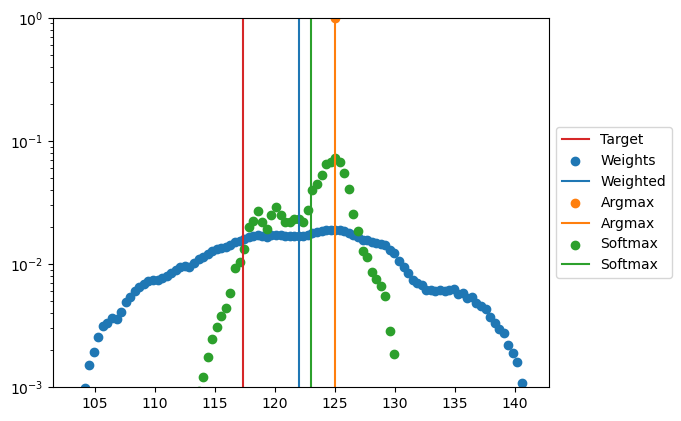

In [492]:
with torch.no_grad():
    samples, labels = dataset[123]
    samples_hv = encoder(samples).sign()
    similarity = model(samples_hv)

    x = torch.linspace(TARGET_MIN, TARGET_MAX, model.num_levels)
    values = (torch.arange(model.num_levels) / (model.num_levels - 1)) * (model.levels.high - model.levels.low) + model.levels.low
    values.unsqueeze_(-1)

    weighted = similarity - torch.min(similarity, dim=-1, keepdim=True).values
    weighted = weighted / torch.sum(weighted, dim=-1, keepdim=True)
    argmax = torch.argmax(similarity, dim=-1, keepdim=True)
    argmax = torch.nn.functional.one_hot(argmax, num_classes=model.num_levels).float()
    softmax = torch.softmax(similarity / 200, dim=-1)

    plt.axvline(labels.item() * (TARGET_MAX - TARGET_MIN) + TARGET_MIN, 0, 1, color="C3", label="Target")

    plt.scatter(x.tolist(), weighted.tolist(), label="Weights")
    plt.axvline((weighted @ values).item() * (TARGET_MAX - TARGET_MIN) + TARGET_MIN, 0, 1, color="C0", label="Weighted")

    plt.scatter(x.tolist(), argmax.tolist(), label="Argmax")
    plt.axvline((argmax @ values).item() * (TARGET_MAX - TARGET_MIN) + TARGET_MIN, 0, 1, color="C1", label="Argmax")

    plt.scatter(x.tolist(), softmax.tolist(), label="Softmax")
    plt.axvline((softmax @ values).item() * (TARGET_MAX - TARGET_MIN) + TARGET_MIN, 0, 1, color="C2", label="Softmax")

    plt.yscale("log")
    plt.ylim(0.001, 1)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    # plt.tight_layout()

plt.show()